# Automatic sleep staging

This notebook demonstrates how to perform automatic sleep staging of polysomnography data in YASA. For more details, make sure to read the [eLife publication](https://elifesciences.org/articles/70092).

Please install the latest version of YASA first with: `pip install --upgrade yasa`.

In [27]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as markdown
from IPython.display import display
from IPython.display import Latex as latex
from tqdm.notebook import tqdm, trange
import os
from time import time, ctime

In [3]:
import warnings
warnings.filterwarnings("ignore")
mne.set_log_level('ERROR')

Functions:

## Data loading

The automatic sleep staging function requires that the data are loaded using the [MNE Python package](https://mne.tools/stable/index.html). For instance, if your polysomnography data are stored in the standard European Data Fomat (.edf), you can use [this function](https://mne.tools/stable/generated/mne.io.read_raw_edf.html?highlight=read_raw_edf#mne.io.read_raw_edf) to load the data into Python.

In [4]:
def make_hypno (raw, evs, annot_id, event_id):
    """ Make proper hypnogram from raw data and events. Used in import_subject_mne_edf().

    Parameters:
    -----------
    raw : mne.io.Raw object
    evs : MNE events array
    annot_id : dict. keys are stage names in file, values are coded stage you want.
    event_id : dict. keys are stage names in file, values are stage numbers for mne.


    """
    ## What we'll need for the function
    rev_an_id = {event_id[k]:v for k,v in annot_id.items()}
    sfreq = raw.info['sfreq']
    dt = 1/sfreq
    neps = int(len(raw)/(30*sfreq))

    # Make "stage", which is a time series with the same shape as the raw eeg, but contains the sleep stage for that given point 

    stage = np.ones_like(raw.times)

    for i in range(0,len(evs)-1):
        stage[evs[i][0]:evs[i+1][0]] = evs[i+1][2]
    stage[evs[len(evs)-2][0]:] = evs[len(evs)-1][2]

    ev_headers = np.array([stage[int(i*30*sfreq)] for i in range(neps)])
    hypno = np.array([rev_an_id[i] for i in ev_headers])

    return hypno


def import_subject_mne_edf(sid=0, arm='temazepam', recs=0, remove_file=False):
    """Import subject's mne edf file and return raw object and hypnogram. Dependent on make_hypno().


    Parameters:
    -----------
        sid : int. subject id. 0-82 for 'tamazepam', 0-21 for 'age'.
        arm : str. 'tamazepam' or 'age'. The dataset arm to import from.
        recs : int. index of recording for each subject to import.
        remove_file : bool. optional. if True, will remove the edf file after importing [do it if you are trying to save total space].
        
    Returns:
    --------
        raw : mne.io.Raw object
        hypno : hypnogram array
    """
    mne.set_log_level(50)
    dsobj=getattr(mne.datasets.sleep_physionet, arm)
    nrecs=len(dsobj.fetch_data(subjects=[sid], on_missing='ignore'))
    if arm=='temazepam':
        [[e,h]] = dsobj.fetch_data(subjects=[sid], on_missing='ignore')
        raw = mne.io.read_raw(e, preload=True, verbose=None)
        # print('The channels are:', raw.ch_names)
        # print('The sampling frequency is:', raw.info['sfreq'])
        raw.set_channel_types({'EEG Fpz-Cz': 'eeg',
                                'EEG Pz-Oz': 'eeg',
                                'EOG horizontal': 'eog',
                                'EMG submental': 'emg',
                                'Marker': 'stim'})
    if arm=='age':
        [[e,h]] = getattr(mne.datasets.sleep_physionet, arm).fetch_data(subjects=[sid], recording=[recs+1], on_missing='ignore')
        raw = mne.io.read_raw(e, preload=True, verbose=None, stim_channel='Event marker',misc=['Temp rectal'])
    else:
        print(arm, ' is not a valid arm.')

    # Let's load a recording, directly as an MNE Raw object

    # display(raw)
    
    # Setting events and annotations in MNE format to make MNE happy:
    annot_id={
    'Sleep stage W': 'W',
    'Sleep stage 1': 'N1',
    'Sleep stage 2': 'N2',
    'Sleep stage 3': 'N3',
    'Sleep stage 4': 'N3',
    'Sleep stage R': 'R',
    'Sleep stage ?': '?'
    }

    annots=mne.read_annotations(h, annot_id)
    raw.set_annotations(annots, emit_warning=False)
    # raw.plot(start=60, duration=60,
                #    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                                #  misc=1e-1));

    event_id = {k:i for i,k in enumerate(annot_id.keys())}
    event_id['Sleep stage ?'] = -1
    event_id['Sleep stage 4'] = 3
    event_id['Sleep stage R'] = 4

    evs, stdict = mne.events_from_annotations(raw,event_id=event_id,chunk_duration=30.)

    hypno = make_hypno(raw, evs, annot_id, event_id)
    if remove_file:
        [os.remove(x) for x in [e,h]];

    raw.info['description']="{}_{}_{}".format(arm,sid,recs)

    return raw, hypno

def test_staging(raw, hypno, eeg_name, metadata=None, savefig=False, sid=None):
    """Test YASA's sleep staging on a single subject.
    
    Parameters:
    -----------
    raw : mne.io.Raw object
    hypno : hypnogram array
    eeg_name : string. name of eeg channel
    metadata : pandas dataframe. optional. if provided, will use metadata to test staging.
    savefig : bool. optional. if True, will save a figure of the test results.
    sid : int. optional. but must be provided if savefig==True; it will save a figure of the test results with the specific subject ID in the sleep-modelling scratch folder.
    
    Returns:
    --------
    results : pandas dataframe. contains results of staging.
    """
    # We first need to specify the channel names and, optionally, the age and sex of the participant
    # - "raw" is the name of the variable containing the polysomnography data loaded with MNE.
    # - "eeg_name" is the name of the EEG channel, preferentially a central derivation (e.g. C4-M1). This is always required to run the sleep staging algorithm.
    # - "eog_name" is the name of the EOG channel (e.g. LOC-M1). This is optional.
    # - "emg_name" is the name of the EMG channel (e.g. EMG1-EMG3). This is optional.
    # - "metadata" is a dictionary containing the age and sex of the participant. This is optional.
    sls = yasa.SleepStaging(raw, eeg_name=eeg_name, metadata=metadata)
    # Getting the predicted sleep stages is now as easy as:
    y_pred = sls.predict()
    y_pred = np.array(y_pred, dtype=str)
    accuracy = (hypno == y_pred).sum() / y_pred.size
    
    if raw.info['description'].startswith('temazepam'):
        arm='temazepam'
    elif raw.info['description'].startswith('age'):
        arm='age'

    if savefig:
        fig,ax=plt.subplots(figsize=(14,7));
        ax.plot(y_pred, label='predicted');
        ax.plot(hypno, label='true');
        ax.legend();
        ax.set(title="accuracy for subject {} is: {}%".format(sid, round(accuracy*100, 3)))
        plt.savefig('/home/taha/git/sleep-modelling/scratch/ml-sleep/figures/test_yasa_edf_arm_{}_sid_{}.png'.format(arm, sid));
        plt.close(fig);
    # Let's compare the predicted stages to the true stages
    # results = pd.DataFrame({'true': hypno, 'predicted': y_pred})
    # What is the accuracy of the prediction, compared to the human scoring
    
    return accuracy#,results


#### Testing the `yasa` sleep staging algorithm on 21 subjects from the "tamazepam" arm of the EDF study:

In [ ]:
accs = []
for i in trange(21, desc='testing `yasa` staging for subjects:'):
    mne.set_log_level(50)
    raw, hypno = import_subject_mne_edf(sid=i, arm='temazepam')
    accuracy = test_staging(raw, hypno, eeg_name='EEG Fpz-Cz', metadata=None, savefig=True, sid=i)
    accs = np.append(accs, accuracy)

testing `yasa` staging for subjects::   0%|          | 0/21 [00:00<?, ?it/s]

The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The channels are: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental', 'Marker']
The sampling frequency is: 100.0
The chan

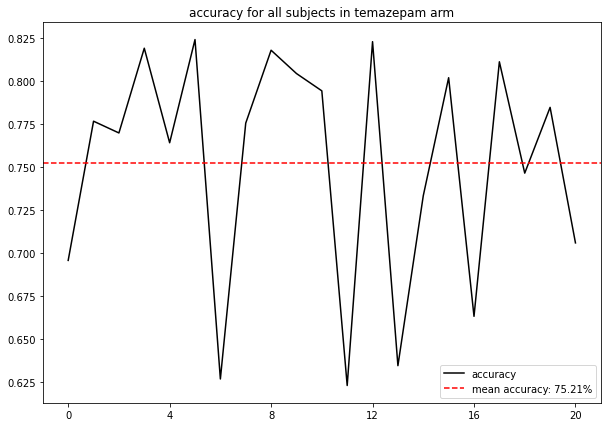

In [ ]:
fig,ax=plt.subplots(figsize=(10,7));
ax.plot(accs, label='accuracy', color='k')
ax.axhline(y=accs.mean(), color='r', linestyle='--', label='mean accuracy: {}%'.format(round(accs.mean()*100, 3)))
ax.set(title="accuracy for all subjects in temazepam arm", xticks=np.arange(start=0,stop=21, step=4, dtype=int))
ax.legend(loc='lower right')
plt.show()

testing `yasa` staging for subjects:   0%|          | 0/81 [00:00<?, ?it/s]

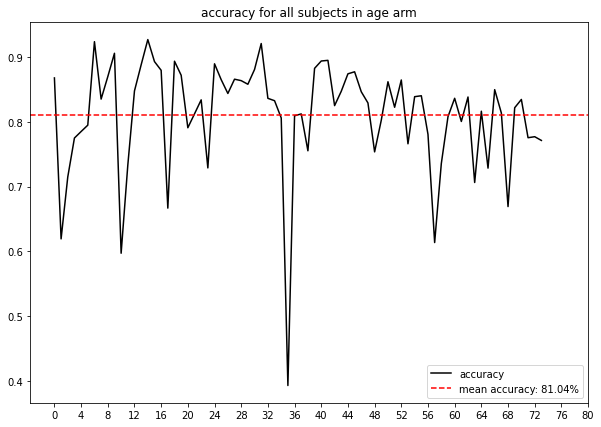

In [ ]:
accs=[]
fails=[]
hypnodict={'N1':1,'N2':2,'N3':3,'R':4,'W':0}

for i in trange(81, desc='testing `yasa` staging for subjects'):
    try:
        mne.set_log_level(50)
        raw, hypno = import_subject_mne_edf(sid=i, arm='age', recs=0)
        accuracy = test_staging(raw, hypno, eeg_name='EEG Fpz-Cz', metadata=None, savefig=True, sid=i)
        accs = np.append(accs, accuracy)
    except ValueError:
        fails.append(i)
        continue

fig,ax=plt.subplots(figsize=(10,7));
ax.plot(accs, label='accuracy', color='k')
ax.axhline(y=accs.mean(), color='r', linestyle='--', label='mean accuracy: {}%'.format(round(accs.mean()*100, 3)))
ax.set(title="accuracy for all subjects in age arm", xticks=np.arange(start=0,stop=82, step=4, dtype=int))
ax.legend(loc='lower right')
plt.show()

#### Observation:

Subjects who have **very long "W"** periods at the start are **lower accuracy**. Staying in a stage very long throws the algo off, because staying in a stage for a long time is penalized in gradient boosting criteria. 

#### Let's trim the data and see how it goes:

We'll cut the data off so that we have 300 seconds of wake (5 mins) at the end and beginning of the data. An upgrade from the current (>1 hour).

13404.41s - Error inserting pydevd breaks.
Traceback (most recent call last):
  File "/home/taha/envs/yasa-env/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 328, in insert_pydevd_breaks
    for new_instruction in get_instructions_to_add(
  File "/home/taha/envs/yasa-env/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/pydevd_modify_bytecode.py", line 102, in get_instructions_to_add
    Instr("LOAD_CONST", _pydev_stop_at_break, lineno=stop_at_line - 1),
  File "/home/taha/envs/yasa-env/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 171, in __init__
    self._set(name, arg, lineno)
  File "/home/taha/envs/yasa-env/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydevd_frame_eval/vendored/bytecode/instr.py", line 239, in _set
    _check_lineno(lineno)
  File "/home/taha/envs/yasa-env/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_py

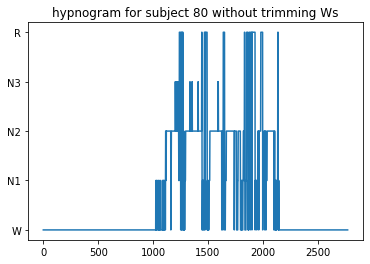

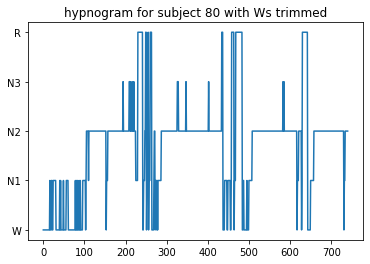

In [278]:
plt.plot(hypno);
plt.title('hypnogram for subject {} without trimming Ws'.format(i));
plt.show();
plt.plot(hypno[(np.where(hdiff!=0)[0][0]-10):(np.where(hdiff!=0)[0][-1]+10)]);
plt.title('hypnogram for subject {} with Ws trimmed'.format(i));
plt.show();

In [9]:
firstN=np.where(hd!=0)[0][0]-offset # first non-W stage (before subject falls asleep), with 10 epochs padding
lastN=np.where(hd!=0)[0][-1]+offset # last non-W stage (when subject wakes up), with 10 epochs padding


In [52]:
accs=[]
fails=[]
hypnodict={'N1':1,'N2':2,'N3':3,'R':4,'W':0, '?':0}

offset = 10 # number of epochs to trim from the W sections at the start and end of the hypnogram
t0 = time()
print('we started at {}'.format(ctime(t0)), "-- using this because apparantly `tqdm` is on sick leave.")
for i in range(82):
    if i == 73: # this one can't do the after-offset. Because it ends at N1.
        t1=time()
        try:
            mne.set_log_level(50)
            raw, hypno = import_subject_mne_edf(sid=i, arm='age', recs=0)
            hd = np.diff(np.array(
                            [hypnodict[k]
                            for k in hypno]
                            )
                )
            firstN=np.where(hd!=0)[0][0]-offset # first non-W stage (before subject falls asleep), with 10 epochs padding
            lastN=np.where(hd!=0)[0][-1] # last non-W stage (when subject wakes up), with 10 epochs padding
            first_idx=int(firstN*30*raw.info['sfreq'])
            last_idx=int(lastN*30*raw.info['sfreq'])
            raw = raw.crop(tmin=raw.times[first_idx], tmax=raw.times[last_idx])
            trimmed_hypno = hypno[firstN:lastN]
            accuracy = test_staging(raw, trimmed_hypno, eeg_name='EEG Fpz-Cz', metadata=None, savefig=True, sid=i)
            accs = np.append(accs, accuracy)
        except ValueError:
            fails.append(i)
            pass
        t2=time()
        deltaT=round(t2-t1, 2)
        print("finished subject {}. This iteration took {} seconds. With this pace, Total esimated {} seconds and finish at {}                                      ".format(i, deltaT, round(deltaT*82,2), ctime(t0+round(deltaT*82,2))), end='\r')
    else:
        t1=time()
        try:
            mne.set_log_level(50)
            raw, hypno = import_subject_mne_edf(sid=i, arm='age', recs=0)
            hd = np.diff(np.array(
                            [hypnodict[k]
                            for k in hypno]
                            )
                )
            firstN=np.where(hd!=0)[0][0]-offset # first non-W stage (before subject falls asleep), with 10 epochs padding
            lastN=np.where(hd!=0)[0][-1]+offset # last non-W stage (when subject wakes up), with 10 epochs padding
            first_idx=int(firstN*30*raw.info['sfreq'])
            last_idx=int(lastN*30*raw.info['sfreq'])
            raw = raw.crop(tmin=raw.times[first_idx], tmax=raw.times[last_idx])
            trimmed_hypno = hypno[firstN:lastN]
            accuracy = test_staging(raw, trimmed_hypno, eeg_name='EEG Fpz-Cz', metadata=None, savefig=True, sid=i)
            accs = np.append(accs, accuracy)
        except ValueError:
            fails.append(i)
            pass
        t2=time()
        deltaT=round(t2-t1, 2)
        print("finished subject {}. This iteration took {} seconds. With this pace, Total esimated {} seconds and finish at {}                                      ".format(i, deltaT, round(deltaT*82,2), ctime(t0+round(deltaT*82,2))), end='\r')

we started at Tue Aug 30 12:55:46 2022 -- using this because apparantly `tqdm` is on sick leave.


okay it actually finished at Tue Aug 30 13:32:53 2022                                                                                                                                                        


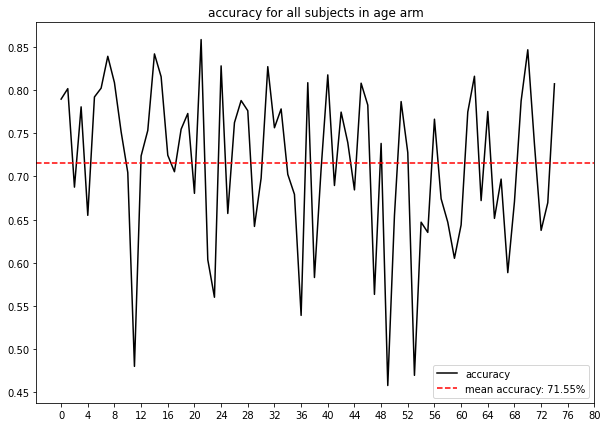

In [53]:


print('okay it actually finished at {}                                                                                                                                                        '.format(ctime(time())))

accs=np.array(accs)
fig,ax=plt.subplots(figsize=(10,7));
ax.plot(accs, label='accuracy', color='k')
ax.axhline(y=accs.mean(), color='r', linestyle='--', label='mean accuracy: {}%'.format(round(accs.mean()*100, 3)))
ax.set(title="accuracy for all subjects in age arm", xticks=np.arange(start=0,stop=82, step=4, dtype=int))
ax.legend(loc='lower right')
plt.show()

## Sleep staging

Automatic sleep stages classification can be done since YASA 0.4.0 using the [SleepStaging](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) class. Make sure to read the [documentation](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging), which explains how the algorithm works.

**Stage probabilities and confidence of the algorithm at each epoch**

In [ ]:
# What are the predicted probabilities of each sleep stage at each epoch?
sls.predict_proba()

,N1,N2,N3,R,W
epoch,,,,,
0,0.000006,0.000499,3.470488e-05,6.121511e-06,0.999454
1,0.000057,0.000005,2.855904e-06,8.422615e-07,0.999934
2,0.000493,0.000034,9.340983e-07,5.350644e-06,0.999467
3,0.002279,0.000065,7.299585e-07,1.570240e-05,0.997639
4,0.003772,0.000176,1.320664e-06,2.218913e-05,0.996028
...,...,...,...,...,...
1191,0.014296,0.006196,1.515758e-03,1.154492e-01,0.862543
1192,0.019775,0.014244,1.011851e-03,1.036061e-01,0.861363
1193,0.011446,0.006174,1.119526e-03,9.462362e-02,0.886637


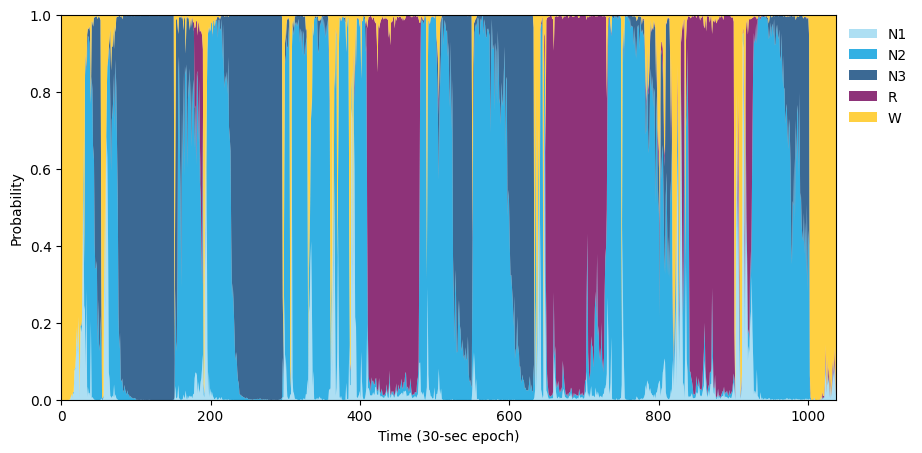

In [ ]:
# Plot the predicted probabilities
sls.plot_predict_proba();

In [ ]:
# From the probabilities, we can extract a confidence level (ranging from 0 to 1) for each epoch.
confidence = sls.predict_proba().max(1)
confidence

epoch
0       0.999896
1       0.999996
2       0.999997
3       0.999995
4       0.999999
          ...   
1033    0.891910
1034    0.927789
1035    0.859646
1036    0.985094
1037    0.861857
Length: 1038, dtype: float64

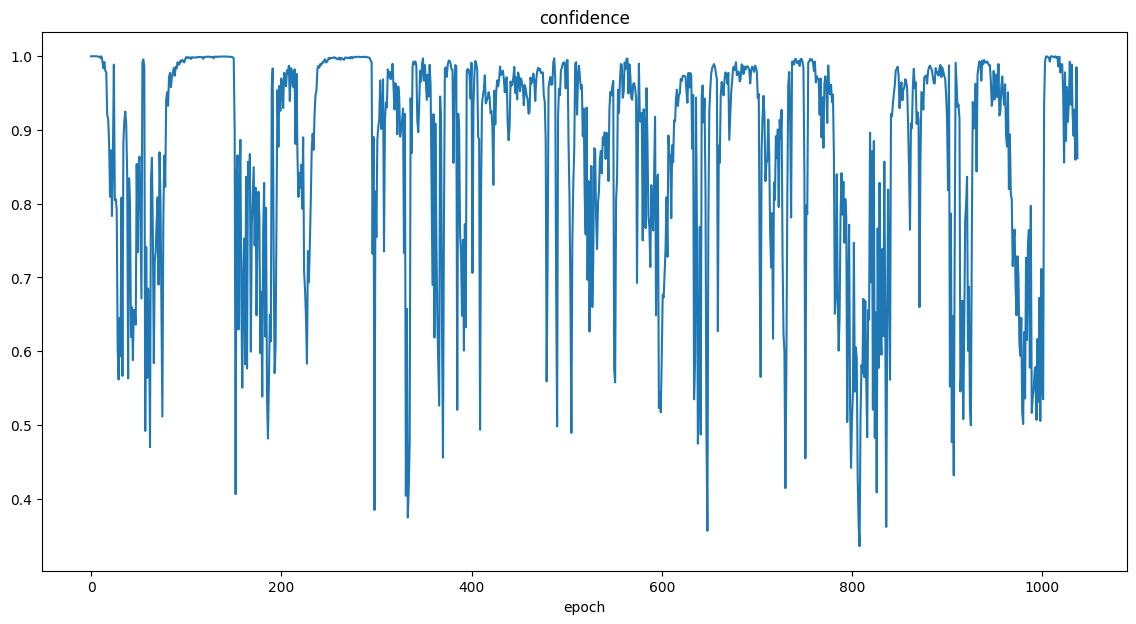

In [ ]:
confidence.plot(figsize=(14,7), title='confidence');

In [ ]:
cf = confidence.to_frame()
cf.columns = ['confidence']
stagecf=cf.join(pd.DataFrame(hypno, columns=['hypno']), how='outer')
stagecf.set_index(['hypno'])

,confidence
hypno,
N1,0.999896
N1,0.999996
N1,0.999997
N1,0.999995
N1,0.999999
...,...
W,0.891910
W,0.927789
W,0.859646


In [ ]:
stagecf.groupby(['hypno']).aggregate(np.mean)

,confidence
hypno,
N1,0.809064
N2,0.830272
N3,0.991962
R,0.909727
W,0.886748


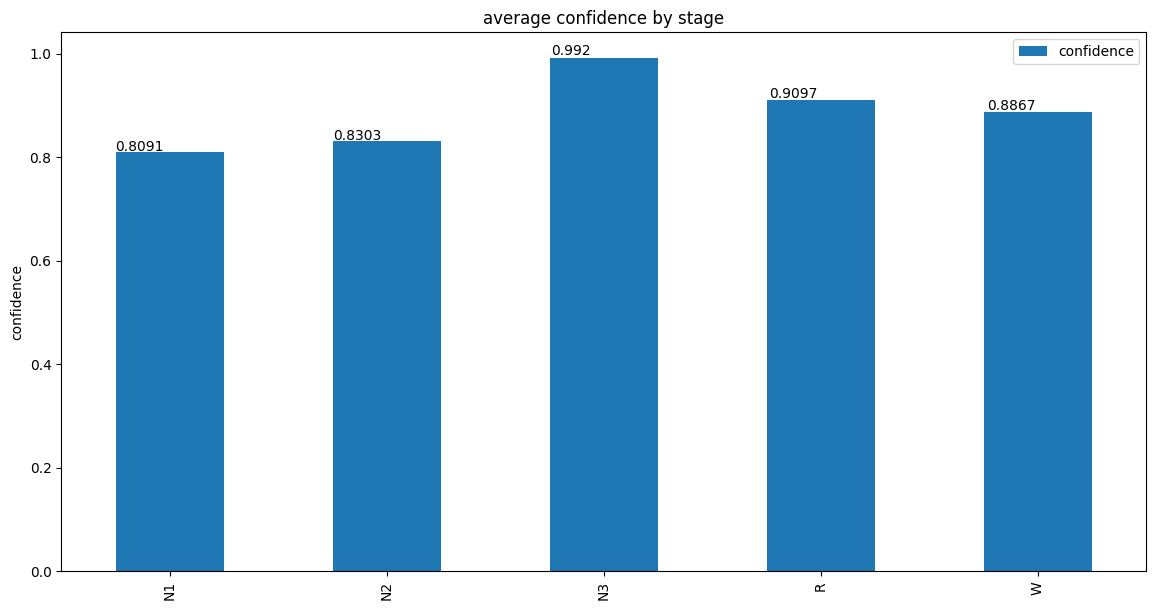

In [ ]:
ax = stagecf.groupby(['hypno']
                    ).aggregate(np.mean
                                ).plot(
                                    kind='bar',
                                    figsize=(14,7),
                                    title='average confidence by stage',
                                    xlabel='',
                                    ylabel='confidence');
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 4)), (p.get_x() * 1.005, p.get_height() * 1.005))

<AxesSubplot:xlabel='epoch'>

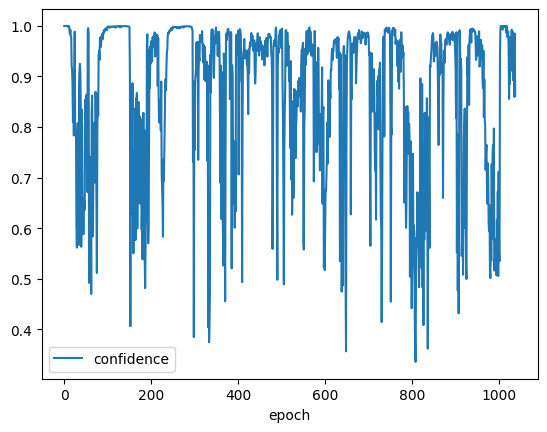

In [ ]:
stagecf.plot()

,0
epoch,
0,0.999896
1,0.999996
2,0.999997
3,0.999995
4,0.999999
...,...
1033,0.891910
1034,0.927789
1035,0.859646


**Exporting to a CSV file**

In [ ]:
# Let's first create a dataframe with the predicted stages and confidence
df_pred = pd.DataFrame({'Stage': y_pred, 'Confidence': confidence})
df_pred.head(6)

# Now export to a CSV file
# df_pred.to_csv("my_hypno.csv")

,Stage,Confidence
epoch,,
0,W,0.999896
1,W,0.999996
2,W,0.999997
3,W,0.999995
4,W,0.999999
5,W,1.000000


**Applying the detection using only a single EEG derivation**

In [ ]:
# Using just an EEG channel (= no EOG or EMG)
y_pred = yasa.SleepStaging(raw, eeg_name="EEG Fpz-Cz").predict()
y_pred

/home/taha/envs/yasa-env/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array(['W', 'W', 'W', ..., 'W', 'W', 'W'], dtype=object)

In [ ]:
# What is the accuracy of the prediction, compared to the human scoring
accuracy = (hypno == y_pred).sum() / y_pred.size
print("The overall agreement is %.3f" % accuracy)

The overall agreement is 0.770
